# VGG16 Transfer Learning on CBIS DDSM

This notebook exploits Transfer Learning on the VGG16 CNN architecture (pre-trained on ImageNet) for abnormality classification (mass-calcification, benign-malign) on mammography images taken from the CBIS DDSM dataset.

# Environment setup

In [0]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [0]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

# Data pre-processing

In [0]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

The data is prepared following these steps:


1.   Import the training and testing data from numpy arrays
2.   Remove the images and labels related to baseline patches (even indices in the arrays)
3.   Adjust the labels for the classification problem, so that 0 corresponds to 'benign mass', 1 to 'malignant mass', 2 to 'bening calcification' and 3 to 'malignant calcification'
4.   Normalize the pixels to be in the range (0-1) floating point
5.   Replicate the color channel three times, since VGG expects BGR images as input.
6.   Shuffle the training set (and labels accordingly, of course)
7.   Split the training data into 'training' and 'validation' subsets
8.   Build Keras generators for training and validation data

In [0]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2676 	 Test size: 336
Image size: 150x150


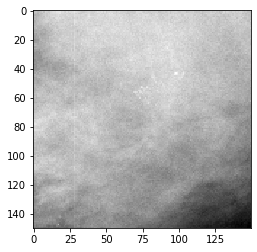

Label: [0. 0. 1. 0.]


In [0]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

# VGG16

## Model definition

In [0]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(150, 150, 3))

    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False

    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128

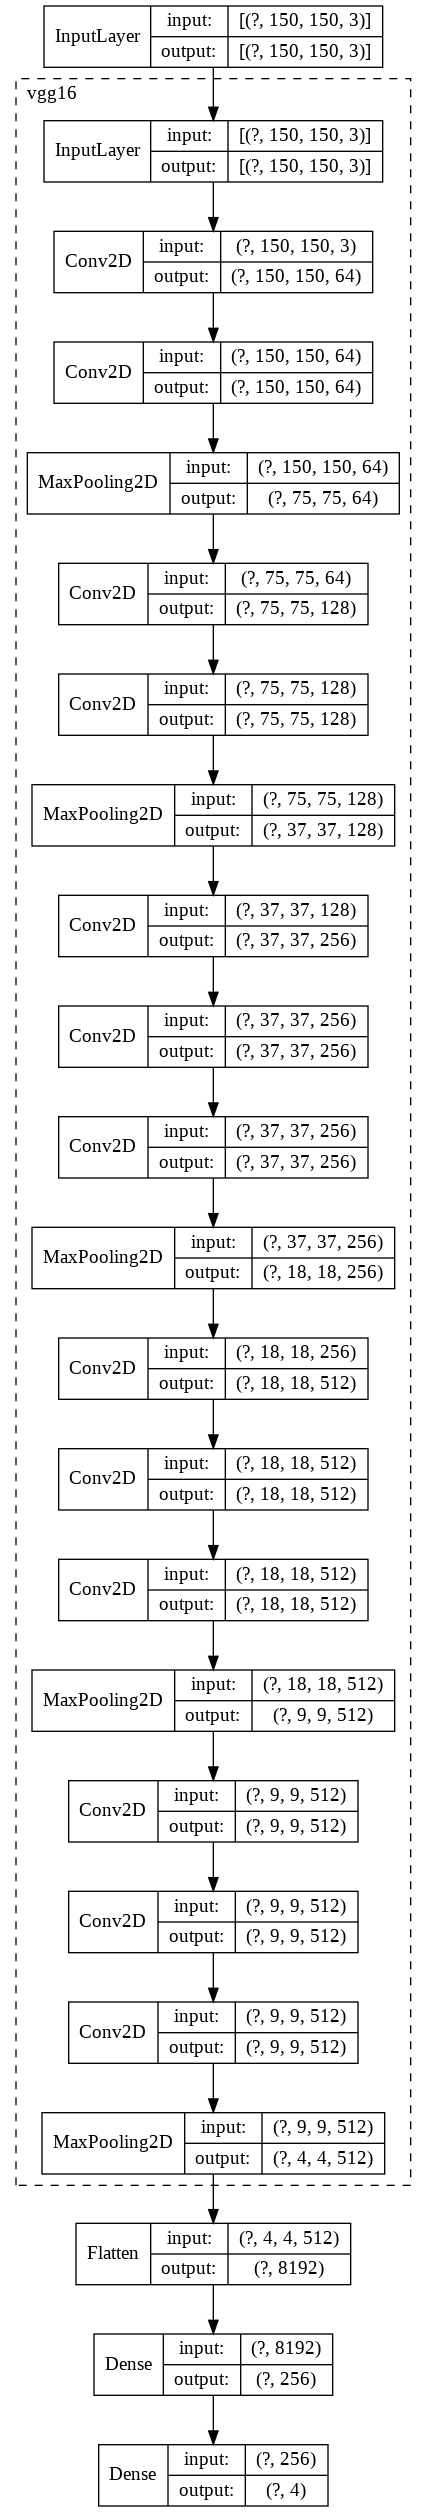

In [0]:
# Show the VGG16 architecture

vgg16_example = create_vgg16(verbose=True)
plot_model(vgg16_example, to_file='vgg16_4class.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

## Feature extraction

### With dropout and 128 neurons FC

Feature extraction with VGG16 on 4 classes is very similar to the 2-class case.
The main difference is in the output layer, composed of 4 softmax neurons instead of a single sigmoidal one. The first experiment is run with a fully-connected layer of 128 units. Dropout is enabled with $p=0.5$ as usual.

In [0]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')
!cp vgg16_fe* "/content/gdrive/My Drive/models/"

Epoch 1/150
 5/20 [======>.......................] - ETA: 15s - loss: 1.1296 - acc: 0.5402
Epoch 00001: val_loss improved from inf to 1.12956, saving model to vgg16_fe_drop_128_4cl_best.h5
20/20 [==============================] - 20s 982ms/step - loss: 3.2647 - acc: 0.4352 - val_loss: 1.1296 - val_acc: 0.5402
Epoch 2/150
 5/20 [======>.......................] - ETA: 14s - loss: 1.0221 - acc: 0.5533
Epoch 00002: val_loss improved from 1.12956 to 1.02206, saving model to vgg16_fe_drop_128_4cl_best.h5
20/20 [==============================] - 14s 723ms/step - loss: 1.2118 - acc: 0.4796 - val_loss: 1.0221 - val_acc: 0.5533
Epoch 3/150
 5/20 [======>.......................] - ETA: 14s - loss: 1.0750 - acc: 0.5383
Epoch 00003: val_loss did not improve from 1.02206
20/20 [==============================] - 15s 770ms/step - loss: 1.1219 - acc: 0.5030 - val_loss: 1.0750 - val_acc: 0.5383
Epoch 4/150
 5/20 [======>.......................] - ETA: 14s - loss: 0.9533 - acc: 0.5514
Epoch 00004: val_lo

In [0]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['acc']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 84
Epoch [opt]: 54
Valid accuracy [end]: 0.6393
Valid accuracy [opt]: 0.6168
Test accuracy [end]:  0.5804
Test accuracy [opt]:  0.5685
Valid loss [end]: 0.9107
Valid loss [opt]: 0.8101
Test loss [end]:  1.0357
Test loss [opt]:  0.9742


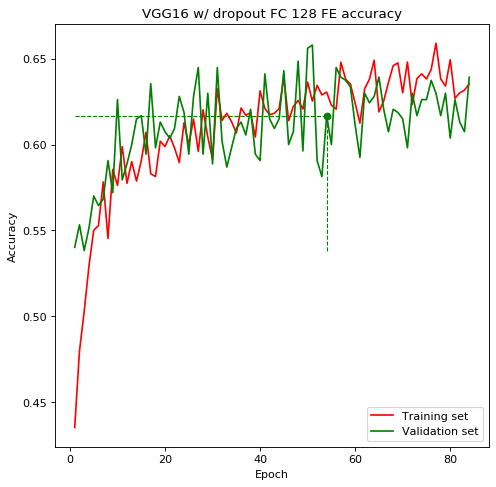

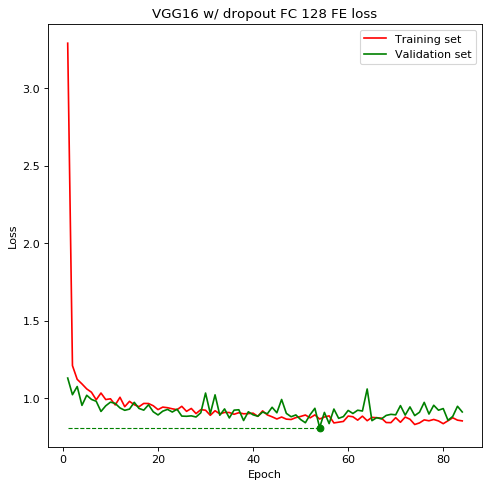

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: The minimum validation loss was reached after 52 epochs, and is equal to 56.8\%. The overfitting here is negligible, and the training loss diminishes very slowly after a while.

### With dropout and 256 neurons FC

The same experiment is repeated with a fully-connected layer of 256 elements.

In [0]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')
!cp vgg16_fe* "/content/gdrive/My Drive/models/"

Epoch 1/150
 5/20 [======>.......................] - ETA: 15s - loss: 1.0865 - acc: 0.5234
Epoch 00001: val_loss improved from inf to 1.08649, saving model to vgg16_fe_drop_256_4cl_best.h5
20/20 [==============================] - 19s 937ms/step - loss: 4.4438 - acc: 0.4388 - val_loss: 1.0865 - val_acc: 0.5234
Epoch 2/150
 5/20 [======>.......................] - ETA: 13s - loss: 1.2187 - acc: 0.5121
Epoch 00002: val_loss did not improve from 1.08649
20/20 [==============================] - 13s 646ms/step - loss: 1.1794 - acc: 0.5061 - val_loss: 1.2187 - val_acc: 0.5121
Epoch 3/150
 5/20 [======>.......................] - ETA: 14s - loss: 1.0895 - acc: 0.5364
Epoch 00003: val_loss did not improve from 1.08649
20/20 [==============================] - 14s 701ms/step - loss: 1.1575 - acc: 0.5020 - val_loss: 1.0895 - val_acc: 0.5364
Epoch 4/150
 5/20 [======>.......................] - ETA: 13s - loss: 1.0755 - acc: 0.5682
Epoch 00004: val_loss improved from 1.08649 to 1.07545, saving model t

In [0]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['acc']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 63
Epoch [opt]: 33
Valid accuracy [end]: 0.6262
Valid accuracy [opt]: 0.5869
Test accuracy [end]:  0.5565
Test accuracy [opt]:  0.5774
Valid loss [end]: 0.9344
Valid loss [opt]: 0.8569
Test loss [end]:  1.0086
Test loss [opt]:  0.9836


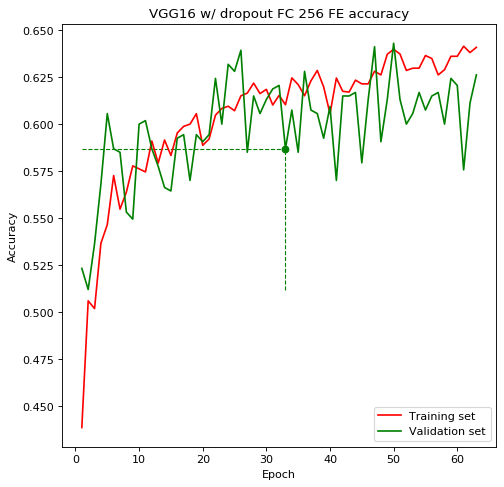

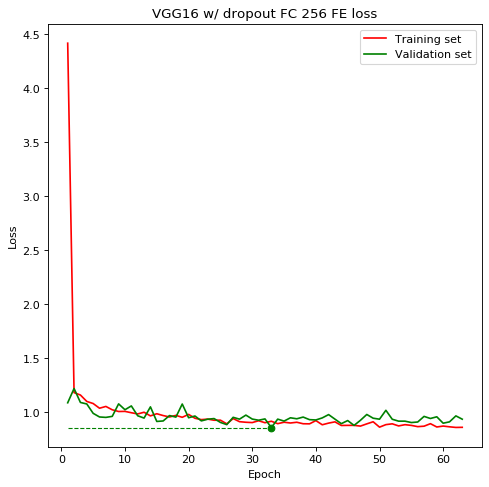

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 256 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 256 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: Although the final testing accuracy slightly increased, doubling the number of FC parameters did not significantly change the performance but, instead, the network started overfitting earlier. A size of 128 is hence the most reasonable choice.

## Fine tuning

The last convolutional layers of VGG16 can be fine-tuned as done before. With more free parameters, networks naturally tend to overfit, so it is better to start from the FC 128 model rather than 256.

### 1 layer

Last layer is fine-tuned with RMSprop and a learning rate of 1e-4.

In [0]:
!cp "/content/gdrive/My Drive/models/vgg16_fe_drop_128_4cl_best.h5" .
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_128_4cl_best.h5')

# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 516       
Total params: 15,763,908
Trainable params: 3,409,028
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [0]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')
!cp vgg16_ft* "/content/gdrive/My Drive/models/"

Epoch 1/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.7906 - acc: 0.6449
Epoch 00001: val_loss improved from inf to 0.79060, saving model to vgg16_ft_1layer_4cl_best.h5
20/20 [==============================] - 19s 970ms/step - loss: 0.8926 - acc: 0.6242 - val_loss: 0.7906 - val_acc: 0.6449
Epoch 2/200
 5/20 [======>.......................] - ETA: 13s - loss: 0.9205 - acc: 0.5869
Epoch 00002: val_loss did not improve from 0.79060
20/20 [==============================] - 13s 625ms/step - loss: 0.8489 - acc: 0.6442 - val_loss: 0.9205 - val_acc: 0.5869
Epoch 3/200
 5/20 [======>.......................] - ETA: 13s - loss: 0.8750 - acc: 0.6280
Epoch 00003: val_loss did not improve from 0.79060
20/20 [==============================] - 15s 735ms/step - loss: 0.8550 - acc: 0.6375 - val_loss: 0.8750 - val_acc: 0.6280
Epoch 4/200
 5/20 [======>.......................] - ETA: 13s - loss: 0.8740 - acc: 0.5888
Epoch 00004: val_loss did not improve from 0.79060
20/20 [==============

In [0]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['acc']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 46
Epoch [opt]: 16
Valid accuracy [end]: 0.6636
Valid accuracy [opt]: 0.6692
Test accuracy [end]:  0.5952
Test accuracy [opt]:  0.5685
Valid loss [end]: 0.7683
Valid loss [opt]: 0.7546
Test loss [end]:  0.9689
Test loss [opt]:  0.9586


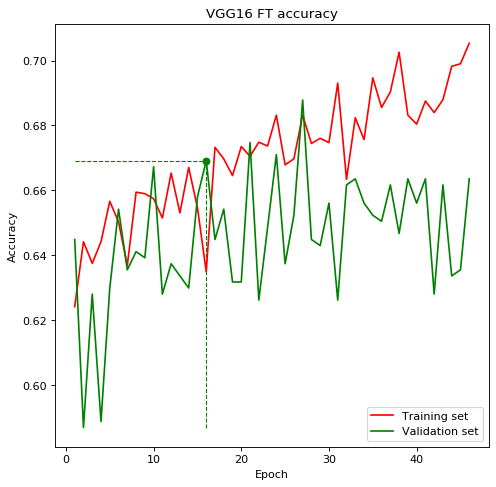

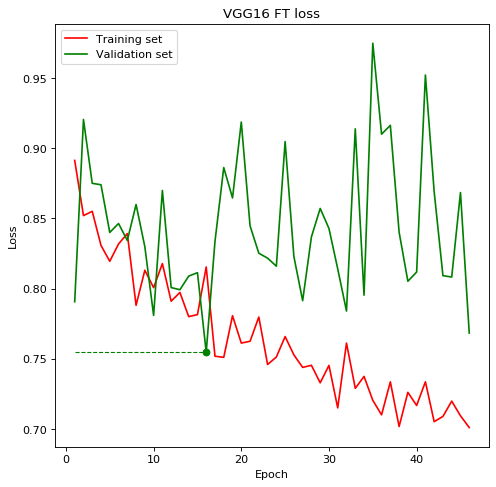

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: The testing accuracy did not change at all, but the validation loss reached a global minimum w.r.t. the previous experiments.

### 2 layers

A second convolutional layer can be adjusted starting from optimal model of the previous experiment.

In [0]:
!cp "/content/gdrive/My Drive/models/vgg16_ft_1layer_4cl_best.h5" .
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 516       
Total params: 15,763,908
Trainable params: 5,768,836
Non-trainable params: 9,995,072
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)        

In [0]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')
!cp vgg16_ft* "/content/gdrive/My Drive/models/"

Epoch 1/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.9270 - acc: 0.6262
Epoch 00001: val_loss improved from inf to 0.92698, saving model to vgg16_ft_2layer_4cl_best.h5
20/20 [==============================] - 20s 1s/step - loss: 1.1047 - acc: 0.6147 - val_loss: 0.9270 - val_acc: 0.6262
Epoch 2/200
 5/20 [======>.......................] - ETA: 13s - loss: 0.8320 - acc: 0.6617
Epoch 00002: val_loss improved from 0.92698 to 0.83199, saving model to vgg16_ft_2layer_4cl_best.h5
20/20 [==============================] - 13s 640ms/step - loss: 0.8324 - acc: 0.6345 - val_loss: 0.8320 - val_acc: 0.6617
Epoch 3/200
 5/20 [======>.......................] - ETA: 13s - loss: 0.8304 - acc: 0.6505
Epoch 00003: val_loss improved from 0.83199 to 0.83040, saving model to vgg16_ft_2layer_4cl_best.h5
20/20 [==============================] - 14s 706ms/step - loss: 0.8294 - acc: 0.6470 - val_loss: 0.8304 - val_acc: 0.6505
Epoch 4/200
 5/20 [======>.......................] - ETA: 13s - loss

In [0]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['acc']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 51
Epoch [opt]: 21
Valid accuracy [end]: 0.6636
Valid accuracy [opt]: 0.6729
Test accuracy [end]:  0.5714
Test accuracy [opt]:  0.6042
Valid loss [end]: 0.9028
Valid loss [opt]: 0.7295
Test loss [end]:  1.3328
Test loss [opt]:  1.0290


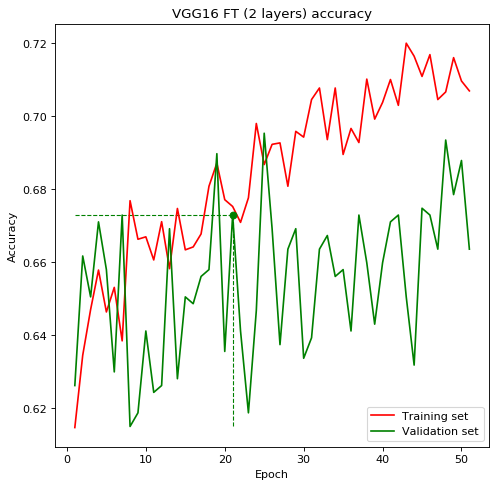

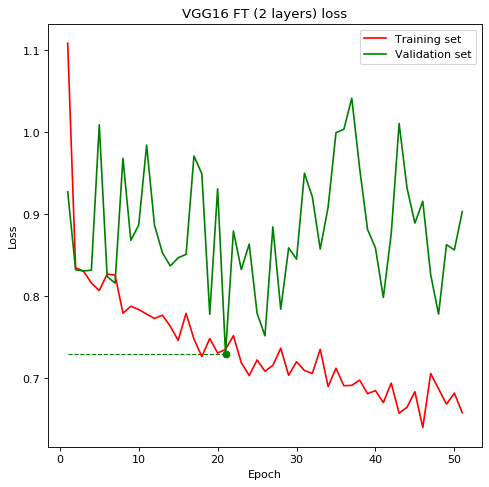

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: The testing accuracy greatly improved, overcoming the threshold of 60\%.

### 3 layers

A third is eventually tuned with a learning rate equal to 1e-5.

In [0]:
!cp "/content/gdrive/My Drive/models/vgg16_ft_2layer_4cl_best.h5" .
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 516       
Total params: 15,763,908
Trainable params: 8,128,644
Non-trainable params: 7,635,264
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)        

In [0]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')
!cp vgg16_ft* "/content/gdrive/My Drive/models/"

Epoch 1/200
 5/20 [======>.......................] - ETA: 14s - loss: 0.9478 - acc: 0.6598
Epoch 00001: val_loss improved from inf to 0.94778, saving model to vgg16_ft_3layer_4cl_best.h5
20/20 [==============================] - 20s 1s/step - loss: 0.6902 - acc: 0.7044 - val_loss: 0.9478 - val_acc: 0.6598
Epoch 2/200
 5/20 [======>.......................] - ETA: 13s - loss: 0.8560 - acc: 0.6748
Epoch 00002: val_loss improved from 0.94778 to 0.85596, saving model to vgg16_ft_3layer_4cl_best.h5
20/20 [==============================] - 13s 628ms/step - loss: 0.6696 - acc: 0.7035 - val_loss: 0.8560 - val_acc: 0.6748
Epoch 3/200
 5/20 [======>.......................] - ETA: 13s - loss: 0.8282 - acc: 0.7047
Epoch 00003: val_loss improved from 0.85596 to 0.82821, saving model to vgg16_ft_3layer_4cl_best.h5
20/20 [==============================] - 14s 705ms/step - loss: 0.6775 - acc: 0.7149 - val_loss: 0.8282 - val_acc: 0.7047
Epoch 4/200
 5/20 [======>.......................] - ETA: 13s - loss

In [0]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['acc']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_acc']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (3 layers)

Epoch [end]: 67
Epoch [opt]: 37
Valid accuracy [end]: 0.7065
Valid accuracy [opt]: 0.6953
Test accuracy [end]:  0.6042
Test accuracy [opt]:  0.5923
Valid loss [end]: 0.7685
Valid loss [opt]: 0.7499
Test loss [end]:  1.1201
Test loss [opt]:  1.0493


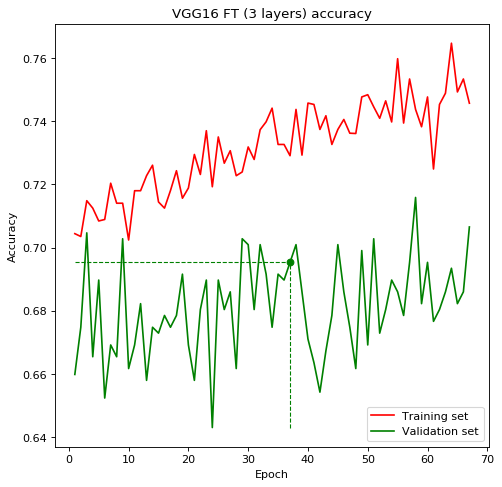

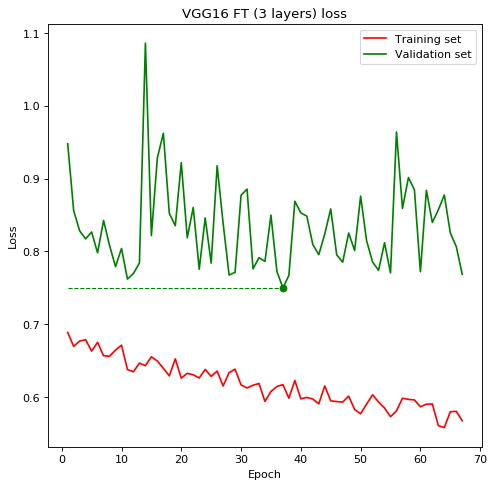

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: The NN became too flexible after unfreezing one more set of parameters, so it failed to achieve a better result than the previous experiment. The accuracy slightly dropped to 59.23\% as a consequence.